# Load Data

In [ ]:
! pip install pytorch_pretrained_bert
! pip install torchmetrics
! pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/Capstone')
from utils import read_conll_file, read_data, filter_tag, create_sub_dir
from utils import DOMAIN_LST, TAG2IDX, IDX2TAG, DATA_DIR, POS_FINE_DIR
from utils import PF_WSJ_DIR
from utils import MODEL_DIR, INT_RESULT_DIR, METRICS_DIR, RESULT_DIR, PLOT_TAGS_DIR
from utils import (wsj_train_word_lst, wsj_train_tag_lst, 
                   wsj_dev_word_lst, wsj_dev_tag_lst,
                   wsj_test_word_lst, wsj_test_tag_lst)

from build_model import PosDataset, Net, DEVICE, TOKENIZER
from build_model import pad, eval

from analysis import save_sns_fig, save_plotly_fig, analysis_output

from create_pseudo_data import gen_pseudo_data

import os
from collections import Counter
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from pytorch_pretrained_bert import BertTokenizer, BertModel
from torchmetrics.functional.classification import multiclass_f1_score, multiclass_precision, multiclass_recall, multiclass_accuracy

torch.manual_seed(0)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The number of samples: 30060
The number of tags 48
The number of samples: 1336
The number of tags 45
The number of samples: 1640
The number of tags 45


In [ ]:
train_dataset = PosDataset(wsj_train_word_lst, wsj_train_tag_lst)
val_dataset = PosDataset(wsj_dev_word_lst, wsj_dev_tag_lst)
test_dataset = PosDataset(wsj_test_word_lst, wsj_test_tag_lst)

train_iter = data.DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=1,
    collate_fn=pad
    )

val_iter = data.DataLoader(
    dataset=val_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=1,
    collate_fn=pad
    )

test_iter = data.DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=1,
    collate_fn=pad
    )

In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

30060
1336
1640


In [ ]:
#@title Train Base Model


model = Net(vocab_size=len(TAG2IDX))
model.to(DEVICE)
model = nn.DataParallel(model)

In [ ]:
def train_one_epoch(model, iterator, optimizer, loss_fn, epoch_index, tb_writer=None):
    running_loss = 0.
    last_loss = 0.

    for i, batch in enumerate(iterator):
      words, x, is_heads, tags, y, seqlens = batch
      
      optimizer.zero_grad()

      # logits, y, y_hat
      logits, y, _ = model(x, y) # logits: (N, T, VOCAB), y: (N, T)

      logits = logits.view(-1, logits.shape[-1]) # (N*T, VOCAB)
      y = y.view(-1)  # (N*T,)

      loss = loss_fn(logits, y)
      loss.backward()

      optimizer.step()

      # Gather data and report
      running_loss += loss.item()
      if (i+1) % 500 == 0:
        last_loss = running_loss / 1000 # loss per batch
        print('  batch {} loss: {}'.format(i + 1, last_loss))
        tb_x = epoch_index * len(iterator) + i + 1
        if tb_writer:
          tb_writer.add_scalar('Loss/train', last_loss, tb_x)
        running_loss = 0.
      
    return last_loss

In [ ]:
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer_path = os.path.join(MODEL_DIR, f'runs/fashion_trainer_{timestamp}')
writer = SummaryWriter(writer_path)

epoch_number = 0
EPOCHS = 5
best_vloss = 1_000_000.

optimizer = optim.Adam(model.parameters(), lr = 0.0001)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train(True)
    avg_loss = train_one_epoch(model, train_iter, optimizer, loss_fn, epoch_number, tb_writer=writer)

    model.train(False)

    running_vloss = 0.0
    for i, vbatch in enumerate(val_iter):
      words, x, is_heads, tags, y, seqlens = vbatch

      logits, y, _ = model(x, y)
      logits = logits.view(-1, logits.shape[-1]) # (N*T, VOCAB)
      y = y.view(-1)  # (N*T,)
      
      vloss = loss_fn(logits, y)
      running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = os.path.join(MODEL_DIR, f'base_model_{timestamp}_{epoch_number}')
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

In [ ]:
# !pip install tensorboard
# !tensorboard --logdir=runs

In [ ]:
#@title Load Model


model_name = [name for name in os.listdir(MODEL_DIR) if "base_model_" in name][0]
model_file = os.path.join(MODEL_DIR, model_name)
print(model_file)

model = Net(vocab_size=len(TAG2IDX))
model.to(DEVICE)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(model_file))

/content/drive/MyDrive/Colab Notebooks/Capstone/model/base_model_20230105_184923_0


<All keys matched successfully>

In [ ]:
# (prec_avg, rec_avg, f1_avg, acc_avg, 
#  prec_micro, rec_micro, f1_micro, acc_micro, 
#  prec_macro, rec_macro, f1_macro, acc_macro) = eval(
#     model, test_iter, save_output=False, output_file=None)

# print(prec_avg, rec_avg, f1_avg, acc_avg)
# print(prec_micro, rec_micro, f1_micro, acc_micro)
# print(prec_macro, rec_macro, f1_macro, acc_macro)

In [ ]:
avg_domain_prec_lst = []
avg_domain_rec_lst = []
avg_domain_f1_lst = []
avg_domain_acc_lst = []

micro_domain_prec_lst = []
micro_domain_rec_lst = []
micro_domain_f1_lst = []
micro_domain_acc_lst = []

macro_domain_prec_lst = []
macro_domain_rec_lst = []
macro_domain_f1_lst = []
macro_domain_acc_lst = []

In [ ]:
DOMAIN_LST

['answers', 'emails', 'newsgroups', 'reviews', 'weblogs']

In [ ]:
base_model_result = os.path.join(RESULT_DIR, "Base_model_result")



Domain wsj
The number of samples: 1336
The number of tags 45
The number of samples: 1640
The number of tags 45
after filter tag 1336
after filter tag 1640


Domain answers
The number of samples: 1745
The number of tags 49
The number of samples: 1744
The number of tags 50
after filter tag 1713
after filter tag 1723


Domain emails
The number of samples: 2450
The number of tags 49
The number of samples: 2450
The number of tags 48
after filter tag 2427
after filter tag 2402


Domain newsgroups
The number of samples: 1196
The number of tags 49
The number of samples: 1195
The number of tags 49
after filter tag 1190
after filter tag 1180


Domain reviews
The number of samples: 1907
The number of tags 47
The number of samples: 1906
The number of tags 50
after filter tag 1905
after filter tag 1906


Domain weblogs
The number of samples: 1016
The number of tags 47
The number of samples: 1015
The number of tags 49
after filter tag 1016
after filter tag 974


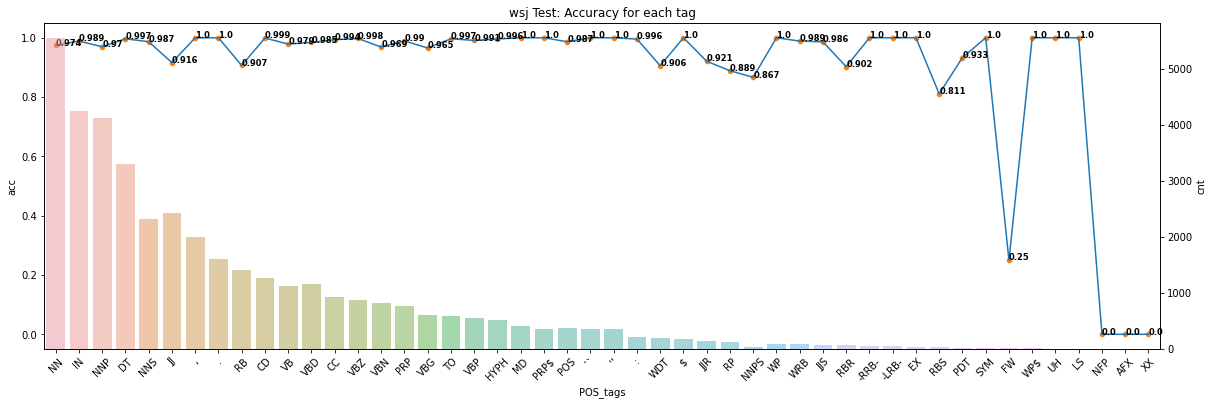

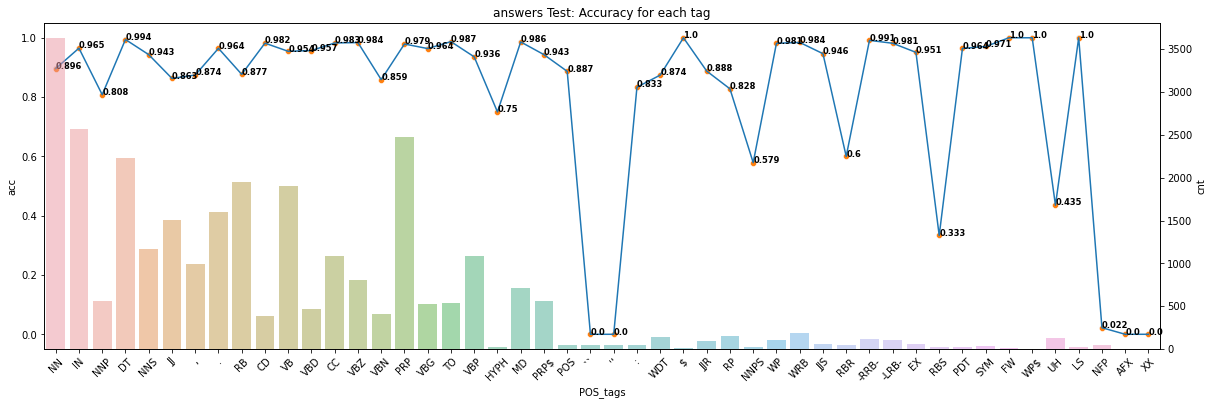

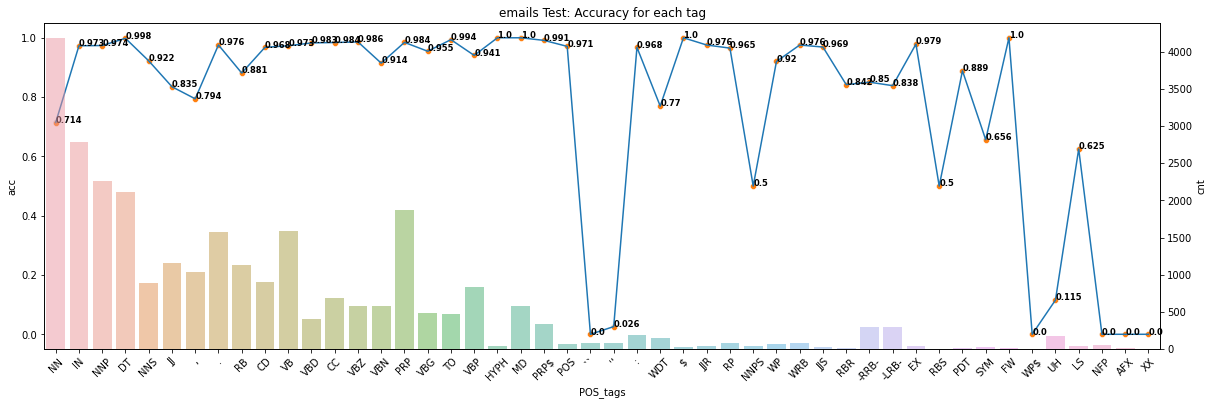

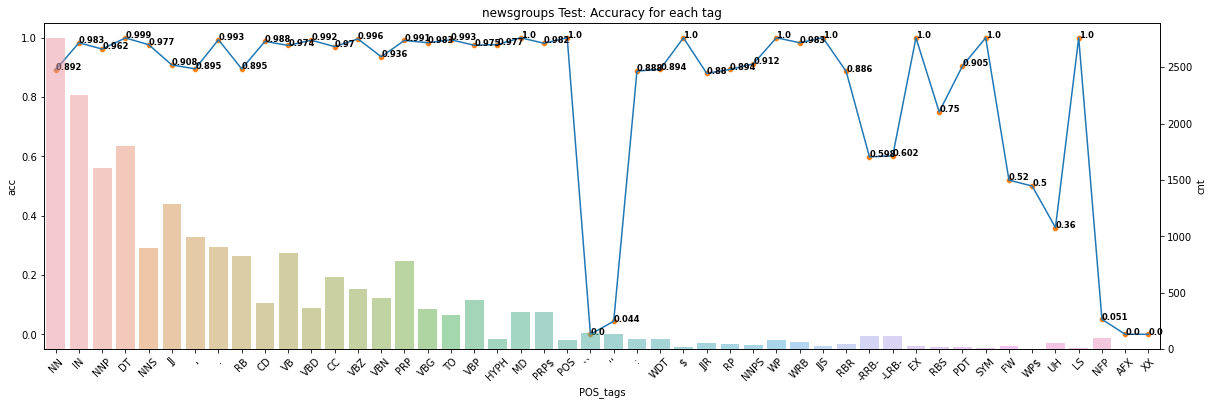

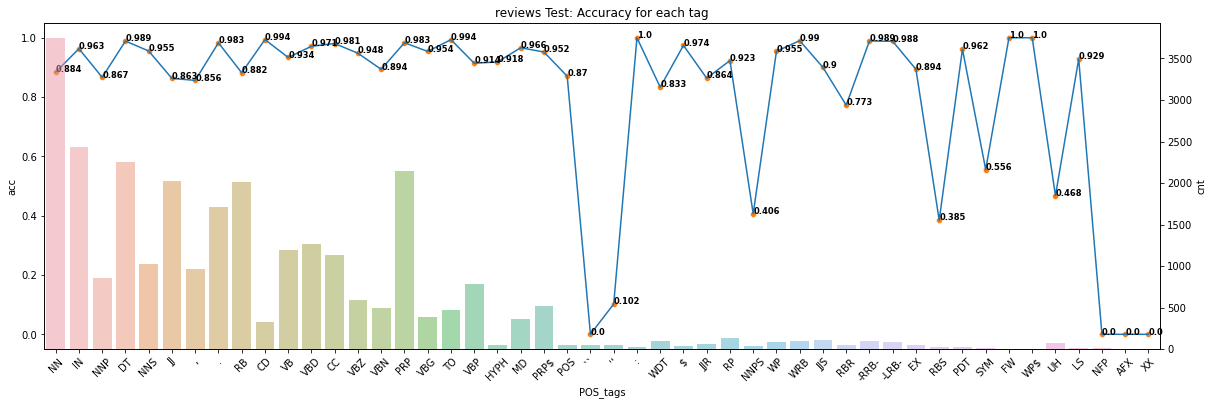

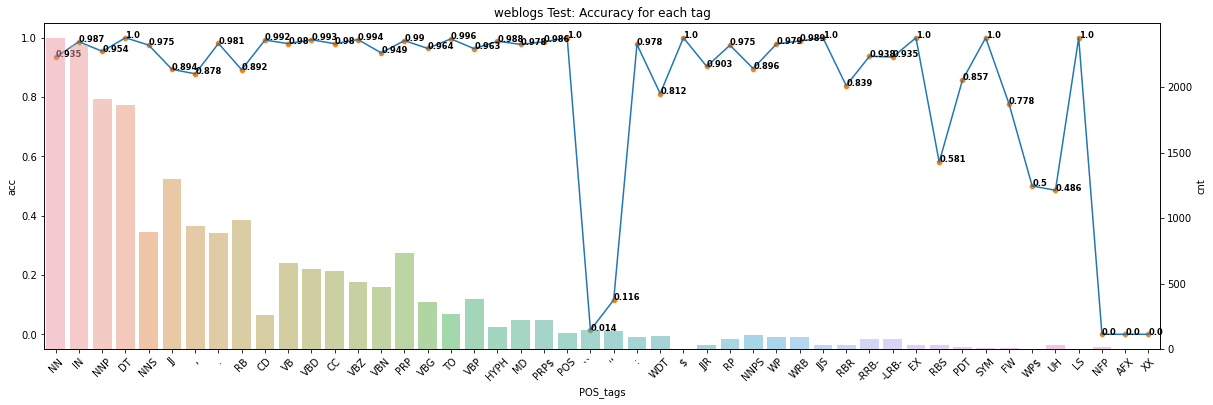

In [ ]:
for domain in ["wsj"]+DOMAIN_LST:
  print("\n")
  print("Domain", domain)
  domain_dir = os.path.join(POS_FINE_DIR, f"{domain}")
  domain_dev_file = os.path.join(domain_dir, f"gweb-{domain}-dev.conll")
  domain_test_file = os.path.join(domain_dir, f"gweb-{domain}-test.conll")

  domain_dev_word_lst, domain_dev_tag_lst, domain_dev_tag_set = read_data(domain_dev_file)
  domain_test_word_lst, domain_test_tag_lst, domain_test_tag_set = read_data(domain_test_file)

  domain_dev_word_lst, domain_dev_tag_lst = filter_tag(domain_dev_word_lst, domain_dev_tag_lst)  
  domain_test_word_lst, domain_test_tag_lst = filter_tag(domain_test_word_lst, domain_test_tag_lst)

  dev_dataset = PosDataset(domain_dev_word_lst, domain_dev_tag_lst)
  test_dataset = PosDataset(domain_test_word_lst, domain_test_tag_lst)

  # dev_iter = data.DataLoader(
  #     dataset=dev_dataset,
  #     batch_size=16,
  #     shuffle=True,
  #     num_workers=1,
  #     collate_fn=pad)
  test_iter = data.DataLoader(
      dataset=test_dataset,
      batch_size=16,
      shuffle=False,
      num_workers=1,
      collate_fn=pad)
  
  # (dev_prec_avg, dev_rec_avg, dev_f1_avg, dev_acc_avg, 
  #  dev_prec_micro, dev_rec_micro, dev_f1_micro, dev_acc_micro, 
  #  dev_prec_macro, dev_rec_macro, dev_f1_macro, dev_acc_macro) = eval(
  #     model, dev_iter, save_output=False, output_file=None)

  test_res_file = os.path.join(base_model_result, f"{domain}_test.txt")

  (test_prec_avg, test_rec_avg, test_f1_avg, acc_avg, 
   test_prec_micro, test_rec_micro, test_f1_micro, test_acc_micro, 
   test_prec_macro, test_rec_macro, test_f1_macro, test_acc_macro) = eval(
      model, test_iter, save_output=True, output_file=test_res_file)

  csv_file_name = os.path.join(base_model_result, f"{domain}_test.csv")
  output_plot_name = os.path.join(base_model_result, f"{domain}_test.png")

  each_class = analysis_output(
      test_res_file, csvsave=True, pngsave=True, 
      csv_file_name=csv_file_name, output_plot_name=output_plot_name, 
      figtitle=f"{domain} Test: Accuracy for each tag")

  avg_domain_prec_lst.append(test_prec_avg)
  avg_domain_rec_lst.append(test_rec_avg)
  avg_domain_f1_lst.append(test_f1_avg)
  avg_domain_acc_lst.append(acc_avg)

  micro_domain_prec_lst.append(test_prec_micro)
  micro_domain_rec_lst.append(test_rec_micro)
  micro_domain_f1_lst.append(test_f1_micro)
  micro_domain_acc_lst.append(test_acc_micro)

  macro_domain_prec_lst.append(test_prec_macro)
  macro_domain_rec_lst.append(test_rec_macro)
  macro_domain_f1_lst.append(test_f1_macro)
  macro_domain_acc_lst.append(test_acc_macro)


In [ ]:
test_metric = pd.DataFrame({
    "domain": (["wsj"] + DOMAIN_LST) * 4,
    "metric": ["precision"]*6 + ["recall"]*6 + ["f1"]*6 + ["accuracy"]*6,
    "value": avg_domain_prec_lst + avg_domain_rec_lst + avg_domain_f1_lst + avg_domain_acc_lst,
})
fig = px.line(test_metric, x="domain", y="value", color='metric', markers=True, title="Average weighted Metrics")
fig.show()

In [ ]:
test_metric = pd.DataFrame({
    "domain": (["wsj"] + DOMAIN_LST) * 4,
    "metric": ["precision"]*6 + ["recall"]*6 + ["f1"]*6 + ["accuracy"]*6,
    "value": macro_domain_prec_lst + macro_domain_rec_lst + macro_domain_f1_lst + macro_domain_acc_lst,
})
fig = px.line(test_metric, x="domain", y="value", color='metric', markers=True, title="Macro weighted Metrics")
fig.show()

In [ ]:
test_metric = pd.DataFrame({
    "domain": (["wsj"] + DOMAIN_LST) * 4,
    "metric": ["precision"]*6 + ["recall"]*6 + ["f1"]*6 + ["accuracy"]*6,
    "value": micro_domain_prec_lst + micro_domain_rec_lst + micro_domain_f1_lst + micro_domain_acc_lst,
})
fig = px.line(test_metric, x="domain", y="value", color='metric', markers=True, title="Micro weighted Metrics")
fig.show()